# Optimization

Pablo Winant

## Computational Economics (MIE37)

In this tutorial you will learn to code and use common optimization
algorithms for static models.

In [1]:
using ForwardDiff, Plots, Printf, NLsolve, Optim

------------------------------------------------------------------------

## Profit optimization by a monopolist

A monopolist produces quantity $q$ of goods X at price $p$. Its cost
function is $c(q) = 0.5 + q (1-qe^{-q})$

The consumer’s demand for price $p$ is $x(p)=2 e^{-0.5 p}$ (constant
elasticity of demand to price).

**Write down the profit function of the monopolist and find the optimal
production (if any). Don’t use any library except for plotting.**

- If markets clear we have c(p) = q

$$ \begin{align} 
\max_{p} p.q(p) - c(q(p)) & = \max_{p} p 2 e^{-0.5 p} - (0.5 + q (1-q(p)e^{-q(p)})) \\
                          & = \min_{p} - \left[ 2 pe^{-0.5 p} - (0.5 + 2 e^{-0.5 p} (1-2 e^{-0.5 p})) \right] = F(p)
\end{align} 
$$

$\textrm{\color{blue} Minimization via Newton-Raphson with Backtraking Armijo line-search}$

**Let $\alpha \in (0,1/2)$, $\beta \in (0,1)$ and $\Delta x$ be the *direction* :**

**Newton-Raphson : $\Delta x_{NR} = - [f^{''}(x)]^{-1}.f^{'}(x) = - [H(x)]^{-1}.\nabla f(x)$**

- $t_k = \beta^{k} \in \mathbf{R}$
- **Iterate over k until :** $f(x+t_k\Delta x) < f(x) + \alpha \nabla f(x)^{T} t_k\Delta x$
- **Then $x_{n+1} = x_n+t_k\Delta x$**

$\textrm{\underline{Armijo condition} : the reduction in f be at least a fraction } \alpha \text{ of the reduction promised by the first-order Taylor approximation of f in x}$

<div>
<img src="./img/backtraking.png" width="500"/>
</div>

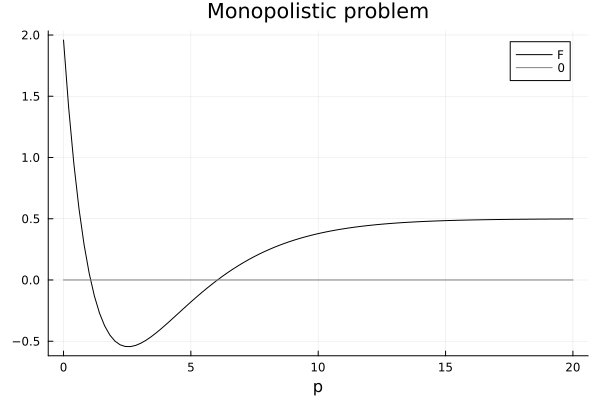

In [2]:
f1(p) = 2*exp(-0.5*p)
f2(p) = p*f1(p) - (0.5+f1(p)*(1-f1(p)*exp(-f1(p))))
plot(range(0, 20, length=100), -f2.(range(0, 20, length=100)), color="black", label="F", title="Monopolistic problem", xaxis="p")
plot!(range(0, 20, length=100),[0 for i in range(0, 20, length=100)], color="gray", line=(:line, 1), label="0")

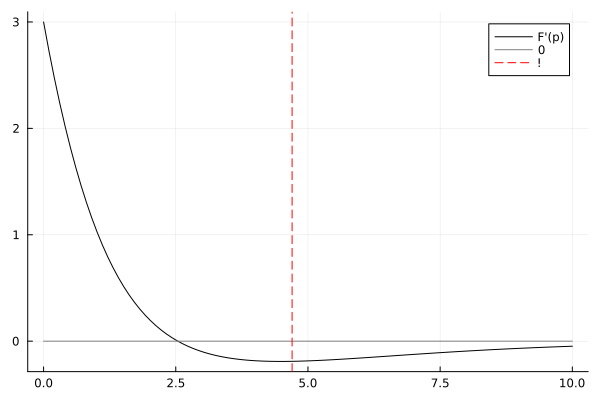

In [3]:
f3(p) = ForwardDiff.derivative(f2,p)
plot(range(0, 10, length=100), f3.(range(0, 10, length=100)), color="black", label="F'(p)")
plot!(range(0, 10, length=100),[0 for i in range(0, 10, length=100)], color="gray", line=(:line, 1), label="0")
vline!([4.7],line=(:dash, 1), color="red", label="!")
#plot(range(0, 10, length=100), (u->ForwardDiff.derivative(f3,u)).(range(0, 10, length=100)))

In [4]:
#! --- MIN via Newton-Raphson with backtraking Armijo line-search
function  profit_NR(p0::Float64; N=50, τ_δ=10^(-10))

    q(p) = 2*exp(-0.5*p)
    F(p) = - ( p*q(p) - ( 0.5+q(p)*(1-q(p)*exp(-q(p))) ) )

    p_L = Float64[]
    push!(p_L,p0)
    local δ

    for i in 1:N
        df_p0 = ForwardDiff.derivative(F,p0)
        ddf_p0 = ForwardDiff.derivative(u->ForwardDiff.derivative(F,u),p0)
        # --
        p1 = p0 -  ddf_p0 \ df_p0
        δ = abs(p1 - p0)
        p0 = p1
        push!(p_L,p0)
        # --
    end

    return (;CV=(δ<τ_δ),δ=δ,p=p0, q=-F(p0), p_L=p_L, N=N)

end

profit_NR (generic function with 1 method)

(CV = true, δ = 0.0, p = 2.5393017528720536, q = 0.5448588102944747, p_L = [2.0, 2.4112234438043925, 2.5306190315634396, 2.539259405629744, 2.5393017518602723, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536  …  2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536, 2.5393017528720536], N = 50)

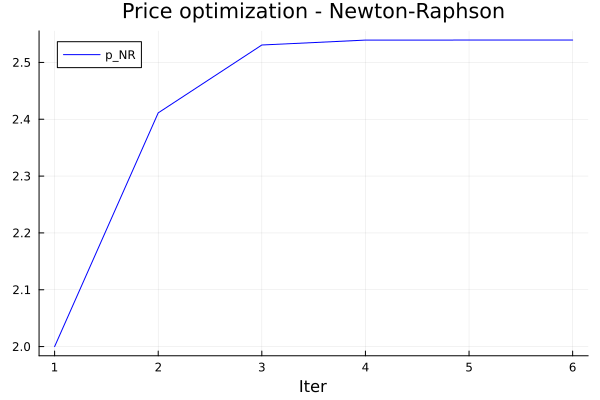

In [5]:
profit_opti_nr = profit_NR(2.0)
display(profit_opti_nr)
display(plot(profit_opti_nr.p_L[1:6], color="blue", label="p_NR", title="Price optimization - Newton-Raphson", xaxis="Iter"))

In [6]:
#! --- MIN via GRADIENT DESCENT
function  profit_GD(p0::Float64; N=50, τ_δ=10^(-10), λ=0.1)

    q(p) = 2*exp(-0.5*p)
    F(p) = - ( p*q(p) - ( 0.5+q(p)*(1-q(p)*exp(-q(p))) ) )
    p_L = Float64[]
    push!(p_L,p0)

    local δ
    for i in 1:N

        p1 = p0 - λ*ForwardDiff.derivative(F,p0)
        δ = abs(p1-p0)
        p0 = p1
        push!(p_L,p0)
    end
    return (;CV=(δ<τ_δ),δ=δ,p=p0, q=-F(p0), p_L=p_L, N=N)
end

profit_GD (generic function with 1 method)

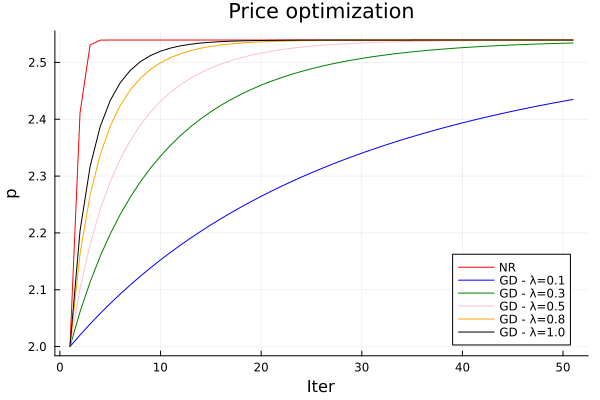

In [7]:
profit_opti_GD1 = profit_GD(2.0)
profit_opti_GD2 = profit_GD(2.0,λ=0.3)
profit_opti_GD3 = profit_GD(2.0,λ=0.5)
profit_opti_GD4 = profit_GD(2.0,λ=0.8)
profit_opti_GD5 = profit_GD(2.0,λ=1.0)

plot(profit_opti_nr.p_L, color="red", label="NR", title="Price optimization", xaxis="Iter", yaxis="p")
plot!(profit_opti_GD1.p_L, color="blue", label="GD - λ=0.1")
plot!(profit_opti_GD2.p_L, color="green", label="GD - λ=0.3")
plot!(profit_opti_GD3.p_L, color="pink", label="GD - λ=0.5")
plot!(profit_opti_GD4.p_L, color="orange", label="GD - λ=0.8")
plot!(profit_opti_GD5.p_L, color="black", label="GD - λ=1.0")

------------------------------------------------------------------------

## Constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

**Use Optim.jl to *maximize* $f$ without constraint. Check you understand
diagnostic information returned by the optimizer.**

**Now, consider the constraint $x<0.3$ and *maximize* $f$ under this new
constraint.**

**Reformulate the problem as a root finding problem with lagrangians.
Write the complementarity conditions.**

**Solve using NLSolve.jl**

In [8]:
f_constrain(z) = - (1 - (z[1]-0.5)^2 - (z[2]-0.3)^2)

res = Optim.optimize(f_constrain, [0.1, 0.2])
Optim.minimizer(res)

2-element Vector{Float64}:
 0.49993816060911933
 0.3000756301799443

In [9]:
function f_constraint_NR(f::Function, z0::Vector{Float64}; N=10, τ_δ=10^(-15))

    function newton(f::Function, z0::Vector{Float64}; N=N, τ_δ=τ_δ)
        z_L = Vector{Float64}[]
        push!(z_L,z0)
        local δ
        for i in 1:N
            df_0 = ForwardDiff.jacobian(u->f(u),z0)
            z1 = z0 - df_0 \ f(z0)
            δ = sum(abs.(z1-z0))
            z0 = z1
            push!(z_L,z0)
        end
        return (; CV=(δ<τ_δ), δ=δ, z=z0, z_L=z_L, N=N)
    end
    
    #! Newton-Raphson to find (local) minimum = Newton on ∇f(x)
    F = (u->ForwardDiff.gradient(f,u))
    res = newton(F,z0)
    return res
end

f_constraint_NR (generic function with 1 method)

In [10]:
f_constraint_NR(f_constrain,[10.0, -2.5])

(CV = true, δ = 0.0, z = [0.5, 0.3], z_L = [[10.0, -2.5], [0.5, 0.2999999999999998], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3], [0.5, 0.3]], N = 10)

In [11]:
# with lower higher bound constraint on x
res2 = Optim.optimize(f_constrain, [-100, -100], [0.2, 100], [-10.0, -5.0])
Optim.minimizer(res2)

2-element Vector{Float64}:
 0.1999999995923647
 0.3000000000016157

- **Lagrangian formulation**

$$ \max_{(x,y)} \mathbf{f(x,y)} {\color{green} \quad sc. \; x<0.3}$$

$$ \min_{(x,y)} -\mathbf{f(x,y)} = f(x,y) {\color{green} \quad sc. \; x<0.3}$$

$$ \textrm{\textbf{Lagrangian : }} \quad \mathcal{L} = f(x,y) + \lambda(0.3 - x) $$

$$\textrm{\textbf{FOCs - KKT : }} \quad \begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}}{\partial x} & = 0 \rightarrow \; \frac{\partial f}{\partial x} = \lambda \\ \\ 
\frac{\partial \mathcal{L}}{\partial y} & = 0 \rightarrow \; \frac{\partial f}{\partial y} = 0 \; \rightarrow y^{\star}(x) \\ \\
\min(\lambda \; ; \; 0.3 - x) & = 0 \rightarrow \; \min\left(\frac{\partial f}{\partial x}(x,y) \; ; \; 0.3-x\right) = 0
\end{align*} \end{cases}
$$

$$ \textrm{\textbf{Fisher-Burmeister : }} \quad \varphi\left( \frac{\partial f}{\partial x}(x,y)\; , \; 0.3-x \right) = 0 \quad \Rightarrow \textrm{Apply Newton root finding} \; \\ 
\textrm{In our case} \; \frac{\partial f}{\partial x}(x,y) \; \textrm{only depends on x so Fisher-Burmeister will only pin down} \; x^{\star}
$$

$$ \textrm{\textbf{Solution : }} \quad z^{\star} = (x^{\star},y^{\star}(x^{\star}))$$

- **We can also add a 'fictious' constraint on y**

$$ \min_{(x,y)} f(x,y) \quad sc. \; x<0.3 \quad {\color{green} "y\geq -\infty" = -10^{5}}$$

$$ \textrm{\textbf{Lagrangian : }} \quad \mathcal{L} = f(x,y) + \lambda(0.3 - x) + \mu(y+10^{5})$$

$$\textrm{\textbf{FOCs - KKT : }} \quad \begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}}{\partial x} & = 0 \rightarrow \; \frac{\partial f}{\partial x} = \lambda \\ \\ 
\frac{\partial \mathcal{L}}{\partial y} & = 0 \rightarrow \; \frac{\partial f}{\partial y} = \mu \\ \\
\min(\lambda \; ; \; 0.3 - x) & = 0 \rightarrow \; \min\left( \frac{\partial f}{\partial x}(x,y) \; ; \; 0.3-x \right) = 0 \\ \\
\min(\mu \; ; \; y+10^{5}) & = 0 \rightarrow \; \min\left( \frac{\partial f}{\partial y}(x,y) \; ; \; y+10^{5} \right) = 0
\end{align*} \end{cases}
$$

$$ \textrm{\textbf{Fisher-Burmeister : }} \quad 
\varphi . \begin{pmatrix} \lambda \; ; \; 0.3 - x \\ \mu \; ; \; y+10^{5} \end{pmatrix} 
= \varphi . \begin{pmatrix} \frac{\partial f}{\partial x}(x,y) \; ; \; 0.3 - x \\ \frac{\partial f}{\partial y}(x,y) \; ; \; y+10^{5} \end{pmatrix} 
= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \rightarrow
F\begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\quad \Rightarrow \textrm{Apply Newton root finding} \; \\ \; \\
\textrm{\textbf{Solution Firsher-Burmeister : }} \; \rightarrow \; (x^{\star},y^{\star}) = z^{\star}
$$

In [89]:
function f_constraint_L(f::Function, z0::Vector{Float64}; N=100, τ_δ=10^(-10),λ=1.0)

    function newton(f::Function, z0::Vector{Float64}; N=N, τ_δ=τ_δ, λ=λ)
        #! dumping sur x
        M_λ = [λ 0.0 ; 0.0 1.0]
        z_L = Vector{Float64}[]
        push!(z_L,z0)
        local δ
        for i in 1:N
            df_0 = ForwardDiff.jacobian(u->f(u),z0)
            #! j'ai dû ajouter un paramètre de 'dumping' pour éviter zigzag sur x
            z1 = M_λ * (z0 - df_0 \ f(z0))
            δ = sum(abs.(z1-z0))
            z0 = z1
            push!(z_L,z0)
        end
        return (; CV=(δ<τ_δ), δ=δ, z=z0, z_L=z_L, N=N, λ=λ)
    end

    φ = ( (a,b)-> a + b - sqrt(a^2 + b^2) )
    df = (u->ForwardDiff.gradient(f, u))
    F(z) = let 
        x = z[1]
        y = z[2]
        φ.( df(z), [0.3-x; y+100] )
    end

    res = newton(F,z0)
    
    return res

end

f_constraint_L (generic function with 1 method)

In [93]:
res_fb_nodump = f_constraint_L(f_constrain, [-1.0, -2.0], N=10)
res_fb_dump1 = f_constraint_L(f_constrain, [-1.0, -2.0], N=10, λ=0.5)
res_fb_dump2 = f_constraint_L(f_constrain, [-1.0, -2.0], N=10, λ=0.6)

(CV = false, δ = 5.754298862403751e-7, z = [0.34965672949124915, 0.2999999999999987], z_L = [[-1.0, -2.0], [0.3223610881288664, 0.24734257725339992], [0.34348027211560955, 0.29997235491648383], [0.34800902958037133, 0.2999999999923746], [0.3491999823336812, 0.2999999999999987], [0.3495289144918458, 0.2999999999999987], [0.3496209753217235, 0.2999999999999987], [0.3496468363212496, 0.2999999999999987], [0.3496541085073905, 0.2999999999999987], [0.3496561540613629, 0.2999999999999987], [0.34965672949124915, 0.2999999999999987]], N = 10, λ = 0.6)

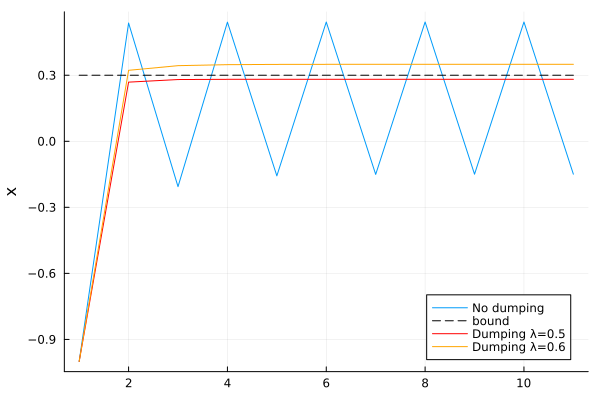

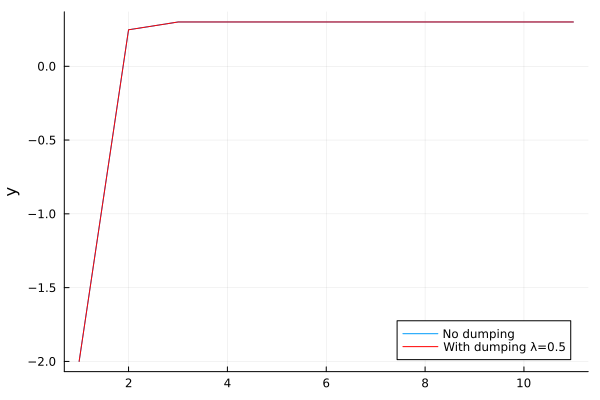

In [105]:
plot([z[1] for z in res_fb_nodump.z_L], label="No dumping", yaxis="x")
plot!([0.3 for i=1:res_fb_nodump.N+1], label="bound", color="black",line=(:dash, 1))
plot!([z[1] for z in res_fb_dump1.z_L], label="Dumping λ=$(res_fb_dump1.λ)", yaxis="x", color="red")
display(plot!([z[1] for z in res_fb_dump2.z_L], label="Dumping λ=$(res_fb_dump2.λ)", yaxis="x", color="orange"))

plot([z[2] for z in res_fb_nodump.z_L], label="No dumping", yaxis="y")
display(plot!([z[2] for z in res_fb_dump.z_L], label="With dumping λ=$(res_fb_dump.λ)", yaxis="y", color="red"))

------------------------------------------------------------------------

## Consumption optimization

A consumer has preferences $U(c_1, c_2)$ over two consumption goods
$c_1$ and $c_2$.

Given a budget $I$, consumer wants to maximize utility subject to the
budget constraint $p_1 c_1 + p_2 c_2 \leq I$.

We choose a Stone-Geary specification where

$U(c_1, c_2)=\beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2)$

**Write the Karush-Kuhn-Tucker necessary conditions for the problem.**

**Verify the KKT conditions are sufficient for optimality.**

**Derive analytically the demand functions, and the shadow price.**

**Interpret this problem as a complementarity problem and solve it using
NLSolve.**

**Produce some nice graphs with isoutility curves, the budget constraint
and the optimal choice.**